In [1]:
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Dense, Conv2D, LeakyReLU, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import tensorflow_datasets as tfds

In [2]:
def build_generator(img_size, latent_dim):
    z = Input(latent_dim)
    x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(z)
    x = Conv2D(512, (3, 3), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2D(256, (3, 3), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2D(128, (3, 3), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2DTranspose(img_size[-1],(3,3),strides=(2,2),padding="same", activation = tf.nn.leaky_relu)(x)
    return Model(z, x)

def build_encoder(img_size, latent_dim):
    x = Input(img_size)
    y = Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(x)
    y = Conv2D(128, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(256, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(256, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(512, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(512, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(latent_dim[-1],(3,3),strides=(2,2),padding="same")(y)
    return Model(x,y)

def build_discriminator(img_size, latent_dim):
    x = Input(img_size)
    z = Input(latent_dim)
    _z = Flatten()(z)
    _z = Dense(img_size[0]*img_size[1]*img_size[2])(_z)
    _z = Reshape(img_size)(_z)

    y = Concatenate()([x,_z])
    y = Conv2D(128, (3, 3), strides=(2, 2), padding="same")(y)
    y = LeakyReLU()(y)
    y = Conv2D(128, (3, 3), padding="same")(y)
    y = LeakyReLU()(y)
    y = Conv2D(256, (3, 3), strides=(2, 2), padding="same")(y)
    y = LeakyReLU()(y)
    y = Conv2D(256, (3, 3), padding="same")(y)
    y = LeakyReLU()(y)
    y = Conv2D(512, (3, 3), strides=(2, 2), padding="same")(y)
    y = LeakyReLU()(y)
    y = Conv2D(512, (3, 3), padding="same")(y)
    y = LeakyReLU()(y)
    y = Conv2D(1024, (3, 3), strides=(2, 2), padding="same")(y)
    y = LeakyReLU()(y)
    y = Conv2D(1024, (3, 3), padding="same")(y)
    y = LeakyReLU()(y)
    y = Flatten()(y)
    y = Dense(1)(y)
    return Model([x, z], [y])



In [3]:
def load_dataset(data_dir, img_size = 64, batch_size = 1):
    df = tf.keras.utils.image_dataset_from_directory(directory = data_dir, 
                                                     labels = None, 
                                                     batch_size= None,
                                                     image_size = (img_size, img_size),
                                                     seed = 42)
    
    return df

In [4]:
data_folder = "sample_data/"
img_dim = 32
train_ds = load_dataset(data_folder+"img", img_size = img_dim, batch_size = 1)

Found 2560 files belonging to 1 classes.


2023-03-23 17:21:14.846324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 17:21:14.901887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 17:21:14.905704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 17:21:14.915206: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
def apply_norm(x):
    return (x*2)/255.0 - 1

In [6]:
latent_dim = (2,2,32)
img_size = (img_dim, img_dim, 3)

enc = build_encoder(img_size, latent_dim)
gen = build_generator(img_size, latent_dim)
disc = build_discriminator(img_size, latent_dim)

g_opt = Adam(learning_rate = 1e-4,  beta_1=0.0, beta_2=0.9)
e_opt = Adam(learning_rate = 1e-4,  beta_1=0.0, beta_2=0.9)
d_opt = Adam(learning_rate = 1e-4,  beta_1=0.0, beta_2=0.9)


In [7]:
num = len(train_ds)

train_ds = train_ds.map(apply_norm)
train_ds = tfds.as_numpy(train_ds)

z_train = np.random.uniform(-1.0, 1.0, (num, )+latent_dim).astype("float32")

In [8]:
import random

t = list(zip(train_ds, z_train))
random.shuffle(t)
train_ds, z_train = zip(*t)

train_ds = np.array(train_ds)
z_train = np.array(z_train)

In [9]:
epochs = 100
batch_size = 32

In [10]:
X_train = train_ds.reshape(-1, batch_size, img_dim, img_dim, 3)
z_train = z_train.reshape(-1, batch_size, latent_dim[0], latent_dim[1], latent_dim[2])

In [11]:
for epoch in tqdm(range(epochs), desc='Total'):
    
    running_loss = [0,0,0]
    num_steps = num//batch_size
    
    perm = np.random.permutation(X_train.shape[0])
    
    X_train = X_train[perm]
    z_train = z_train[perm]
    
    for steps in range(0, num_steps):
        x_batch = X_train[steps]
        z_batch = z_train[steps]
        
        with tf.GradientTape(persistent=True, watch_accessed_variables=True) as tape:      
            fake_img = gen(z_batch)
            fake_z = enc(x_batch)

            preds = disc([tf.concat([fake_img, x_batch], axis = 0) , tf.concat([z_batch, fake_z], axis = 0)])
            pred_gen, pred_enc = tf.split(preds, 2)
            
            gen_loss = tf.reduce_mean(tf.nn.softplus(-pred_gen))
            enc_loss = tf.reduce_mean(tf.nn.softplus(pred_enc))
            
            disc_loss = tf.reduce_mean(tf.nn.softplus(pred_gen)) + tf.reduce_mean(tf.nn.softplus(-pred_enc))

        gen_grad = tape.gradient(gen_loss, gen.trainable_variables)
        disc_grad = tape.gradient(disc_loss, disc.trainable_variables)
        enc_grad = tape.gradient(enc_loss, enc.trainable_variables)

        g_opt.apply_gradients(zip(gen_grad,gen.trainable_variables))
        e_opt.apply_gradients(zip(enc_grad,enc.trainable_variables))
        d_opt.apply_gradients(zip(disc_grad,disc.trainable_variables))

        running_loss[0] += disc_loss.numpy()
        running_loss[1] += gen_loss.numpy()
        running_loss[2] += enc_loss.numpy()
        del tape
    print('[{}] Desc loss : {:.10f}\t Gen Loss : {:.10f}\t Enc Loss : {:.10f}'.format(epoch,running_loss[0],running_loss[1], running_loss[2] ))

Total:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-23 17:21:22.890974: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


[0] Desc loss : 46.6784595144	 Gen Loss : 184.2523035055	 Enc Loss : 588.2774940133
[1] Desc loss : 18.0132761488	 Gen Loss : 449.4319351842	 Enc Loss : 979.7913804054
[2] Desc loss : 15.7569984539	 Gen Loss : 575.1997196004	 Enc Loss : 1067.5727767944
[3] Desc loss : 15.6317821180	 Gen Loss : 525.2948356718	 Enc Loss : 764.9762411118
[4] Desc loss : 20.0771205369	 Gen Loss : 675.1788804829	 Enc Loss : 1165.1126747131
[5] Desc loss : 16.3140392840	 Gen Loss : 631.6007378716	 Enc Loss : 752.5013403893
[6] Desc loss : 21.7004850303	 Gen Loss : 666.7465285528	 Enc Loss : 601.7860977650
[7] Desc loss : 26.0637792582	 Gen Loss : 523.7432515770	 Enc Loss : 499.7628272772
[8] Desc loss : 32.2842039680	 Gen Loss : 473.5173173845	 Enc Loss : 455.1230030060
[9] Desc loss : 35.1268471205	 Gen Loss : 436.6654870287	 Enc Loss : 433.8362014294
[10] Desc loss : 36.9313832048	 Gen Loss : 384.1936338069	 Enc Loss : 449.0437177420
[11] Desc loss : 43.9839773150	 Gen Loss : 369.9043375239	 Enc Loss : 421

[96] Desc loss : 34.9087631204	 Gen Loss : 305.8360876627	 Enc Loss : 1882.6605768204
[97] Desc loss : 45.8259428586	 Gen Loss : 431.4963169859	 Enc Loss : 3146.6861774921
[98] Desc loss : 30.8279282572	 Gen Loss : 348.2616582215	 Enc Loss : 2686.0713663101
[99] Desc loss : 57.2786160782	 Gen Loss : 334.6161101992	 Enc Loss : 2144.3338770866


1/1 [==============================] - 0s 21ms/step


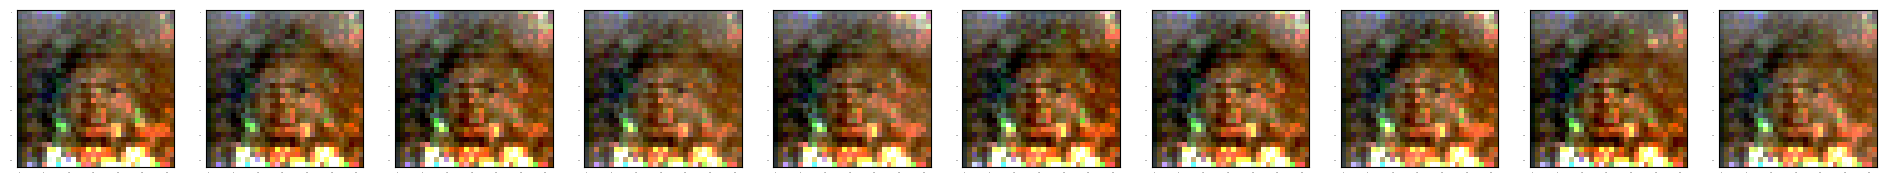

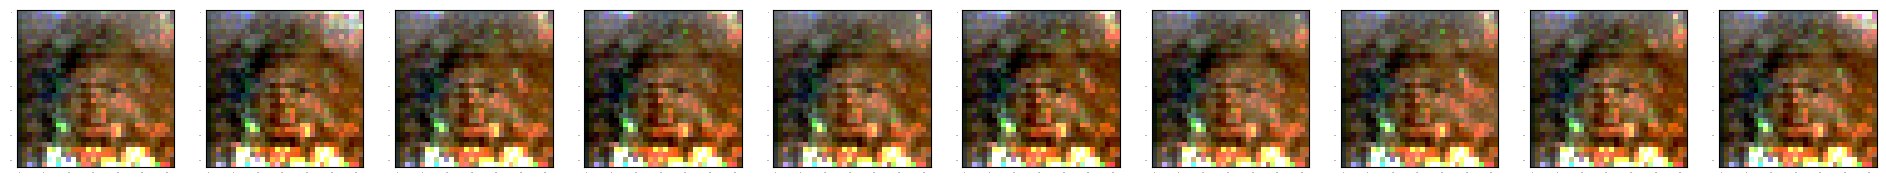

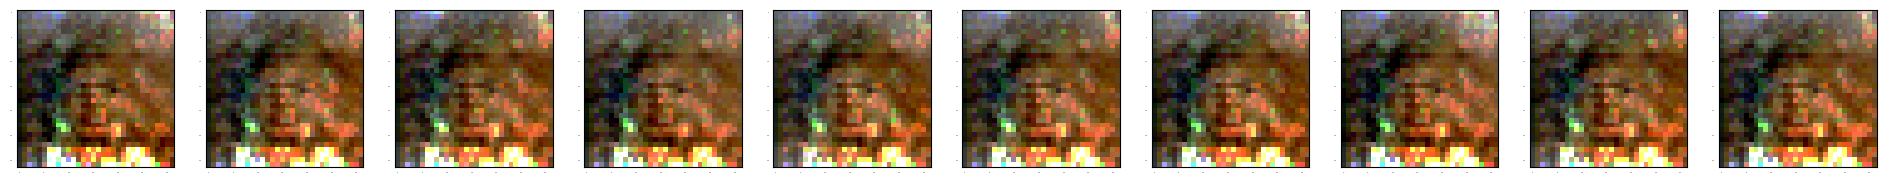

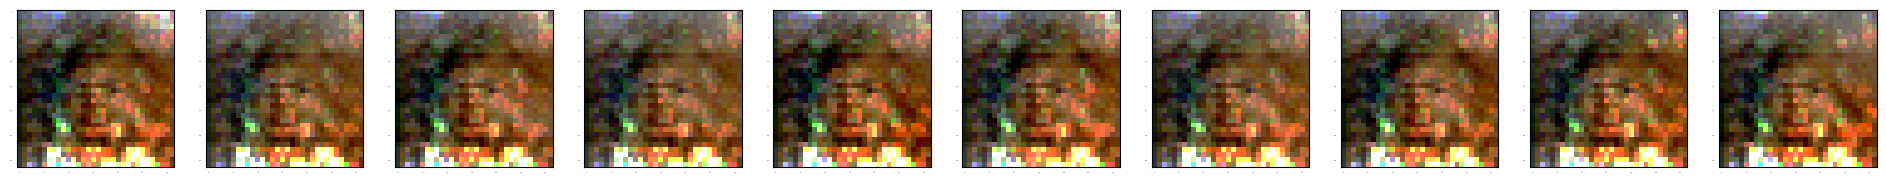

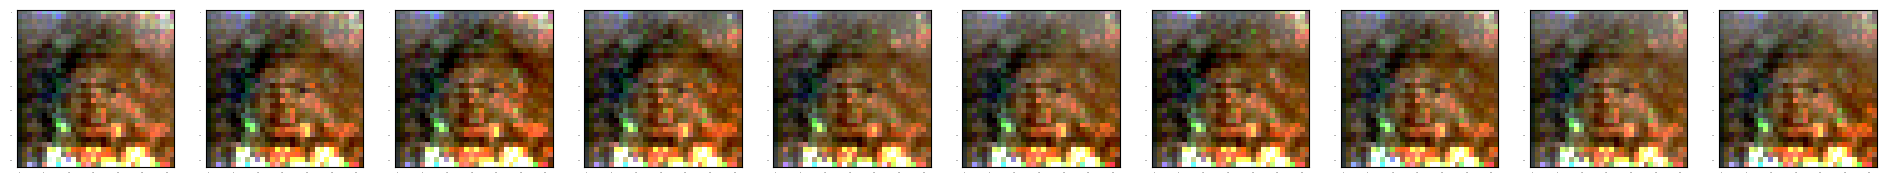

In [12]:
for _ in range(5):
    num_sample = 10
    z_test = np.random.uniform(-1.0, 1.0, (num, )+latent_dim).astype("float32")
    pred = gen.predict(z_test[:num_sample]).reshape(-1, img_dim, img_dim, 3)

    _, axs = plt.subplots(1,num_sample, figsize=(24,12))
    for i in range(num_sample):
        img = np.clip((pred[i]+1)*(255.0/2), 0, 255).astype("uint32")
        axs[i].imshow(img)
        axs[i].tick_params(length=0, labelsize=0)